<h1 align="center">Exploring the breast cancer risk detection by dynamic light scattering: multivariate analysis and logistic regression modeling</h1>
<div align="center">
    <span style="font-size: 18px;">Janeth Fernández-Pinto, Álvaro Gómez-Torrado, and David A. Miranda</span>
</div>
<div align="center">Universidad Industrial de Santander, Cra 27 Cll 9, Bucaramanga, Santander, Colombia, 680002.</div>

## 1. Import Python Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

from scipy.optimize import curve_fit

## 2. Methods

In [2]:
def fitting_function(w, a, b):
    return a / (w**2 + b)

def get_fitting_params(f, y, maxfev=10000, ftol=1e-10, xtol=1e-9, method='trf', verbose=True):
    p, covariance = curve_fit(fitting_function, 2*np.pi*f, y, ftol=ftol, xtol=xtol, method=method, maxfev=maxfev)
    if verbose:
        a, b = p
        print(f'γ: {np.sqrt(b):0.1f}, δ:{np.log(np.pi * a/np.sqrt(b)):0.3g}')
    return p, covariance

In [3]:
def get_power_spectrum_fitting(p, fmin=250, fmax=2500):
    a, b = p
    ffit = np.linspace(fmin, fmax, 1000)
    yfit = fitting_function(2*np.pi*ffit, a, b)
    return ffit, yfit

In [4]:
def plot_particles_power_spectrum(particles_data, particles_info, show_error_bars=False, fontsize=12, dpi=300, fmin=0, fmax=2000, method='trf', maxfev=10000, verbose=True):
    x = particles_data['Frequency (Hz)']
    k = (x >= fmin) & (x < fmax) 
    plt.figure(dpi=dpi, figsize=(6, 6))
    for args in particles_info:
        particle = args['label']
        y = particles_data[particle]
        ymax = max(y[k])
        y /= ymax
        ystd = particles_data[f'std({particle})']/ymax
        p, _ = get_fitting_params(x[k], y[k], maxfev=maxfev, method=method, verbose=verbose)
        xfit, yfit = get_power_spectrum_fitting(p, fmin=fmin, fmax=fmax)
        plt.plot([], [], **args)
        plt.plot(xfit, yfit, color=args['markerfacecolor'], linestyle=args['linestyle'], alpha=0.7, lw=2)
        if show_error_bars:
            plt.vlines(x[k], y[k]-ystd[k], y[k]+ystd[k], colors=args['color'], lw=0.3)
        args['linestyle']='None'
        args['label']=None
        plt.plot(x[k], y[k],**args)
    plt.yticks([])
    plt.xlabel('Frequency (Hz)', fontsize=fontsize)
    plt.ylabel('Power Spectrum (a.u.)', fontsize=fontsize)
    plt.axis()
    plt.xlim(fmin, fmax)
    plt.ylim(0, 1.1)
    _ = plt.legend(edgecolor='none', fontsize=fontsize)

In [5]:
def get_pca(df, columns, n_components=2, target_column='class'):
    features = df[columns]
    target = df[target_column]
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(features)

    # Create a DataFrame for the principal components and target variable
    pca_columns = [f'PC{n+1}' for n in range(n_components)]
    principal_df = pd.DataFrame(data=principal_components, columns=pca_columns)
    principal_df['class'] = target

    # Access the explained variance ratio of each component
    explained_variance_ratio = pca.explained_variance_ratio_

    print('The explained variance ratios for the PCA variables:')
    for i, ratio in enumerate(explained_variance_ratio):
        print(f'  Explained Variance Ratio for PC{i+1}: {ratio}')

    # Access the linear transformation matrix
    transformation_matrix = pca.components_

    print('\nPCA Linear Transformation Matrix:')
    print(transformation_matrix)
    print('')

    return principal_df, pca_columns

In [6]:
def vif_metric(df, columns):
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["Feature"] = columns
    vif["VIF"] = [variance_inflation_factor(df[columns].values, i) for i in range(len(columns))]
    print(vif)

In [7]:
def apply_logistic_modelling(df, pca_columns, dpi=300):
    # Assign the independent variables given in pca_columns and the dependent variable (class)
    X = df[pca_columns]
    y = df['class']

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Create and fit the logistic regression model
    logit_model = sm.Logit(y, X)
    logit_result = logit_model.fit()

    # Print the summary of the logistic regression model
    print(logit_result.summary())

    # Plot the logistic regression model
    if len(pca_columns) == 2:
        plt.figure(dpi=dpi)
        plt.figure(figsize=(8, 6))
        plt.scatter(df[pca_columns[0]], df[pca_columns[1]], c=y, cmap='viridis')
        plt.xlabel(pca_columns[0])
        plt.ylabel(pca_columns[1])

        # Plot the decision boundary for the logistic regression model
        x1 = np.linspace(df[pca_columns[0]].min(), df[pca_columns[0]].max(), 100)
        x2 = np.linspace(df[pca_columns[1]].min(), df[pca_columns[1]].max(), 100)
        X1, X2 = np.meshgrid(x1, x2)
        X_grid = np.c_[X1.ravel(), X2.ravel()]
        X_grid = sm.add_constant(X_grid)
        y_pred = logit_result.predict(X_grid)
        y_pred = np.round(y_pred)
        plt.contourf(X1, X2, y_pred.reshape(X1.shape), alpha=0.3, cmap='viridis')

        plt.colorbar()
        plt.title('Logistic Regression Model')
        plt.show()
    return logit_result, X, y

In [8]:
def apply_roc(logit_result, X, y, dpi=300, fontsize=12):
    # Get the predicted probabilities for the positive class
    y_prob = logit_result.predict(X)

    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_prob)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = roc_auc_score(y, y_prob)

    # Find the cutoff point using Youden's J statistic
    j_scores = tpr - fpr
    best_index = np.argmax(j_scores)
    cutoff_point = thresholds[best_index]

    # Calculate the predicted classes based on the cutoff point
    y_pred = (y_prob >= cutoff_point).astype(int)

    # Calculate the specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Print the cutoff point, specificity, and sensitivity
    print("Cutoff Point:", cutoff_point)
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    print(f'AUC = {roc_auc:.2f}')

    # Plot the ROC curve
    plt.figure(dpi=dpi, figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', zorder=10)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=fontsize)
    plt.ylabel('Sensitivity', fontsize=fontsize)
    plt.gca().set_aspect('equal')  # Set equal aspect ratio for x and y axes
    plt.show()


In [9]:
def apply_logistic_modelling_and_roc(df, pca_columns, dpi=300, fontsize=12):
    logit_result, X, y = apply_logistic_modelling(df, pca_columns, dpi=dpi)
    apply_roc(logit_result, X, y, dpi=dpi, fontsize=fontsize)

## 3. Data for the analysis

In [10]:
data_file_name = 'data/bands_data.csv'
particles_file_name = 'data/particles_data.csv'
dpi = 300

In [11]:
data = pd.read_csv(data_file_name)
data

,class,C2b1,C2b2,C2b3,C2b4,C2b5,C2b6,C0b1,C0b2,C0b3,...,C0b6,C1b1,C1b2,C1b3,C1b4,C1b5,C1b6,C1b6 - C1b1,C1b6 + C1b1,Unnamed: 21
0,1,0.004434,0.053081,0.244553,0.309442,0.311120,0.056988,0.004464,0.053090,0.244661,...,0.056984,0.005192,0.053213,0.242561,0.310982,0.311544,0.056168,0.050976,0.061360,NaN
1,1,0.004499,0.053033,0.244523,0.309426,0.311123,0.057007,0.004379,0.053074,0.244696,...,0.057015,0.005072,0.052940,0.242079,0.310993,0.312432,0.056245,0.051174,0.061317,NaN
2,1,0.004483,0.053046,0.244444,0.309488,0.311174,0.056981,0.004357,0.053098,0.244664,...,0.057020,0.005047,0.053067,0.241899,0.310948,0.312523,0.056242,0.051195,0.061289,NaN
3,1,0.004434,0.053014,0.244549,0.309567,0.311070,0.056982,0.004335,0.053079,0.244668,...,0.057021,0.005104,0.052763,0.240278,0.311899,0.313691,0.056070,0.050966,0.061173,NaN
4,1,0.004515,0.053065,0.244521,0.309419,0.311128,0.056979,0.004510,0.053101,0.244665,...,0.056993,0.005048,0.053283,0.242695,0.310882,0.311600,0.056158,0.051109,0.061206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0,0.004611,0.053228,0.244010,0.310039,0.310775,0.056896,0.005537,0.053584,0.242929,...,0.055408,0.004407,0.053265,0.243865,0.309891,0.311192,0.056936,0.052529,0.061343,NaN
204,0,0.004442,0.053217,0.244194,0.309912,0.310850,0.056922,0.004840,0.053649,0.243612,...,0.055436,0.004437,0.053260,0.243979,0.309760,0.311145,0.056937,0.052500,0.061373,NaN
205,0,0.004426,0.053241,0.244281,0.309734,0.310892,0.056927,0.004844,0.053651,0.243000,...,0.055458,0.004367,0.053069,0.243729,0.309839,0.311499,0.057021,0.052654,0.061387,NaN
206,0,0.004764,0.053224,0.243906,0.310007,0.310787,0.056899,0.005607,0.053261,0.242215,...,0.055424,0.004444,0.053307,0.243726,0.309975,0.311194,0.056931,0.052487,0.061375,NaN


In [12]:
particles_data = pd.read_csv(particles_file_name)
particles_data

,Frequency (Hz),Polyestirene,std(Polyestirene),100-400 nm,std(100-400 nm),60-300 nm,std(60-300 nm),500-1000 nm,std(500-1000 nm)
0,0.000000,2.054628e+07,6.296361e+06,9.076437e+07,1.204866e+07,6.649741e+07,1.253651e+07,9.432202e+07,7.889127e+06
1,326.156556,1.026718e+05,4.105356e+04,4.902759e+05,3.030901e+04,5.664647e+05,1.944118e+05,3.496712e+05,3.918456e+04
2,652.313111,2.725586e+04,9.075343e+03,2.067941e+05,1.633823e+04,2.900848e+05,1.243100e+05,1.518588e+05,1.651459e+04
3,978.469667,1.767178e+04,1.061960e+04,1.169977e+05,8.632466e+03,1.726211e+05,7.940633e+04,8.661772e+04,9.718164e+03
4,1304.626223,9.811289e+03,5.529517e+03,9.813800e+04,8.154919e+03,1.285838e+05,5.353888e+04,7.240582e+04,6.789581e+03
...,...,...,...,...,...,...,...,...,...
507,165361.373800,1.887529e+04,2.018251e+04,8.232696e+04,7.076644e+03,6.036568e+04,4.591459e+03,5.502805e+04,6.208146e+03
508,165687.530300,1.564696e+04,1.663173e+04,7.542275e+04,7.368703e+03,5.511093e+04,5.332125e+03,5.179490e+04,5.024796e+03
509,166013.686900,1.434119e+04,1.519965e+04,6.892082e+04,6.951630e+03,4.927674e+04,4.718648e+03,4.673974e+04,4.994559e+03
510,166339.843400,1.497389e+04,1.602409e+04,7.017972e+04,7.070950e+03,4.800068e+04,3.723455e+03,4.460578e+04,5.151559e+03


### 3.1. Power Spectra of particles

γ: 3558.3, δ:9.59
γ: 3039.9, δ:9.52
γ: 3093.3, δ:9.52
γ: 1322.2, δ:9.55


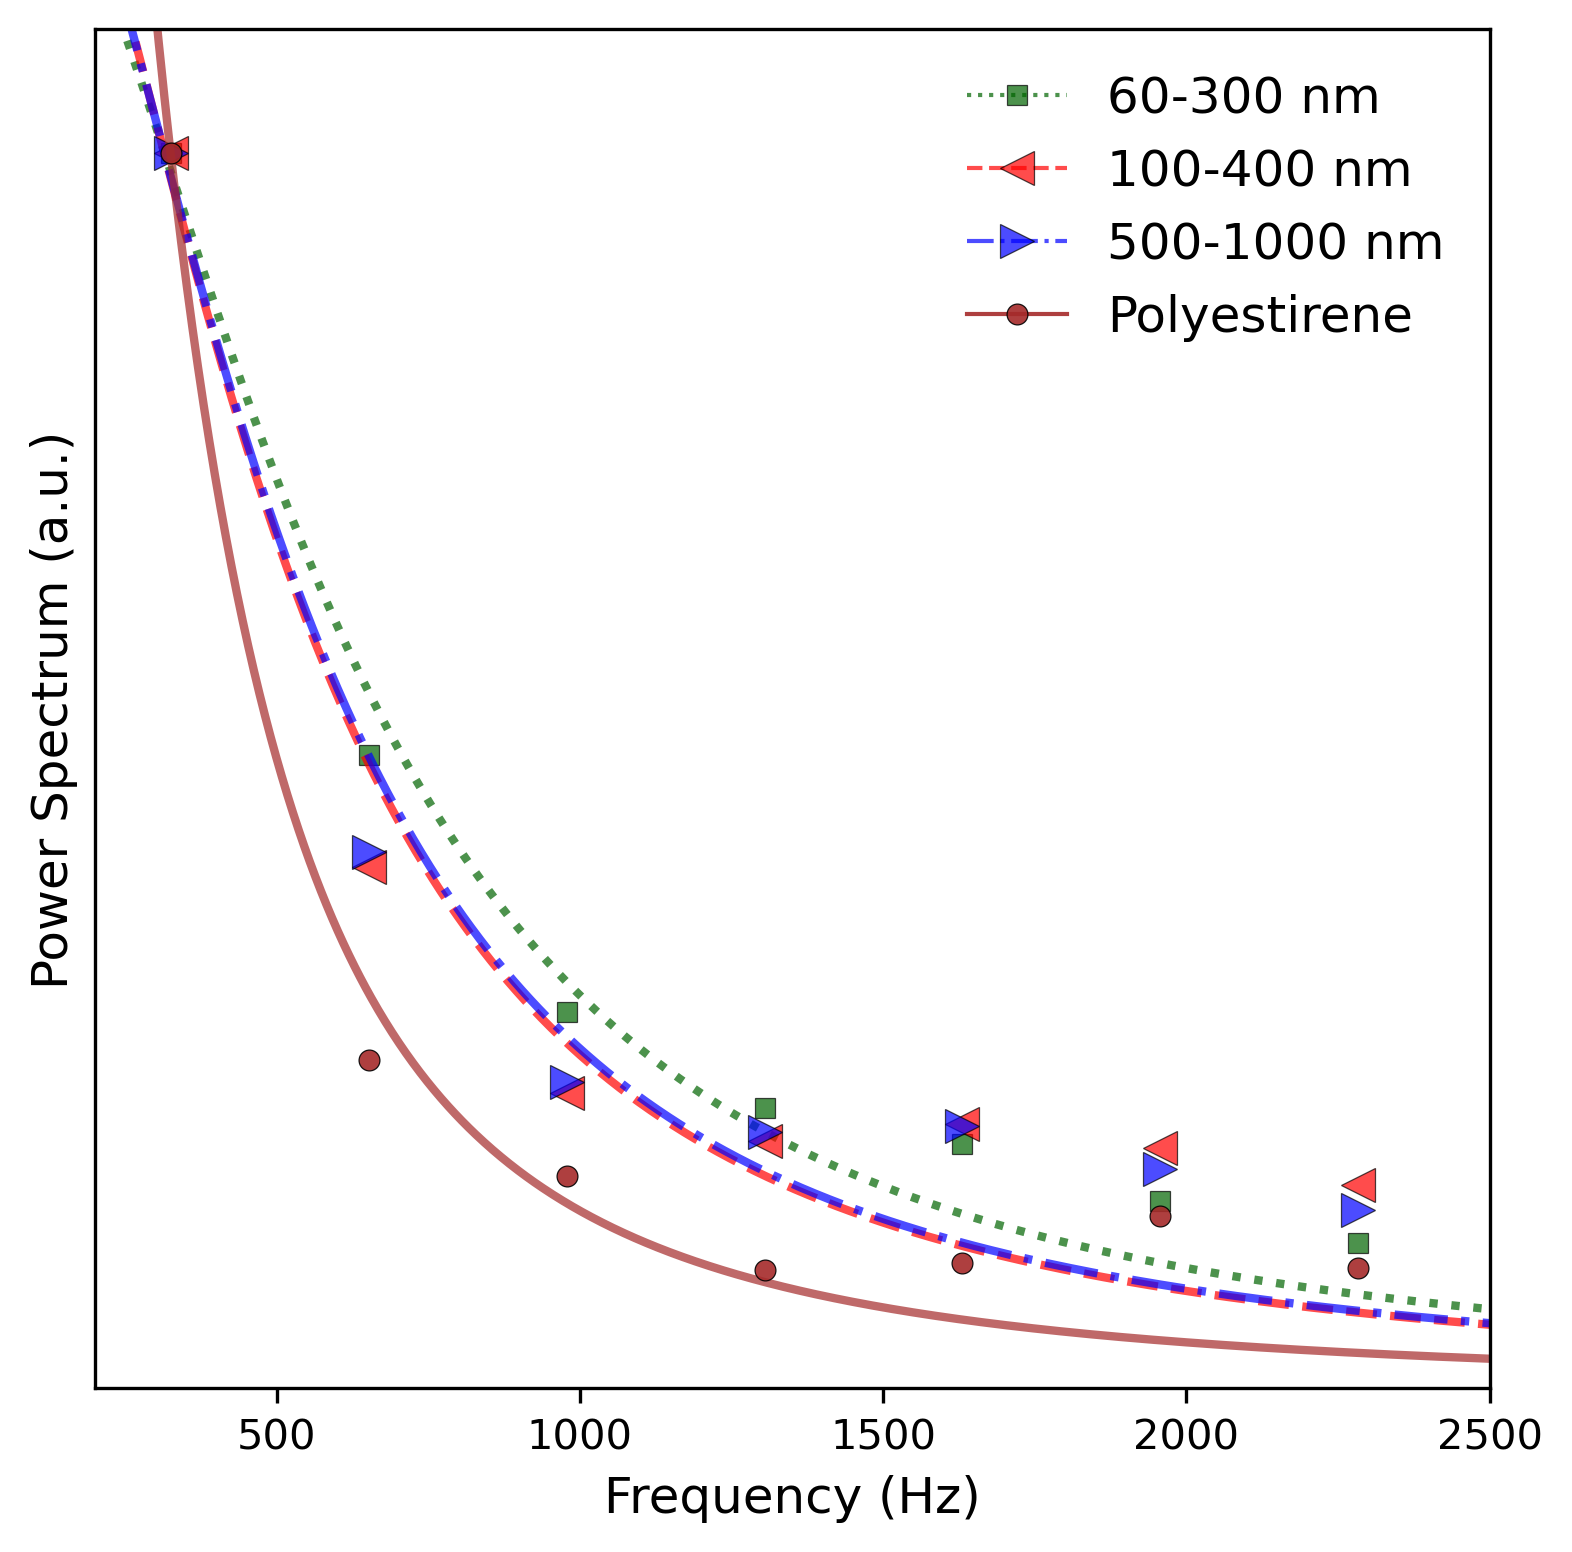

In [13]:
particles_info = [
        {
            'label':'60-300 nm',
            'linestyle':'dotted',
            'marker':'s',
            'markersize':5,
            'linewidth': 1,
            'color':'darkgreen',
            'alpha':0.7,
            'markerfacecolor':'darkgreen',
            'markeredgecolor':'black',
            'markeredgewidth':0.3,
        },
        {
            'label':'100-400 nm',
            'linestyle':'--',
            'marker':'<',
            'markersize':8,
            'linewidth': 1,
            'color':'red',
            'alpha':0.7,
            'markerfacecolor':'red',
            'markeredgecolor':'black',
            'markeredgewidth':0.3,
        },
        {
            'label':'500-1000 nm',
            'linestyle':'-.',
            'marker':'>',
            'markersize':8,
            'linewidth': 1,
            'color':'blue',
            'alpha':0.7,
            'markerfacecolor':'blue',
            'markeredgecolor':'black',
            'markeredgewidth':0.3,
        },
        {
            'label':'Polyestirene',
            'linestyle':'-',
            'marker':'o',
            'markersize':5,
            'linewidth': 1,
            'color':'brown',
            'alpha':0.9,
            'markerfacecolor':'brown',
            'markeredgecolor':'black',
            'markeredgewidth':0.3,
        }, 
    ]
plot_particles_power_spectrum(particles_data, particles_info, fontsize=12, dpi=300, fmin=200, fmax=2500, method='lm', show_error_bars=False)

### 3.2. PDA Analysis

In this section, we conducted a PCA analysis specifically focusing on the channel Dif. Our objective was to explore the data in-depth by utilizing five principal component analysis (PCA) variables.

By narrowing down the analysis to the channel Dif, we aimed to gain a comprehensive understanding of the patterns and variations specific to this channel. The PCA transformation allowed us to derive five independent variables that effectively captured the underlying structure and information within the channel Dif data.

With the use of five PCA variables, we were able to delve deeper into the complexities of the channel Dif and extract meaningful insights. This approach provided a more detailed representation of the channel Dif data, enabling a comprehensive analysis of its distinctive features and characteristics.

In [14]:
columns = ['C2b1', 'C2b2', 'C2b3', 'C2b4', 'C2b5', 'C2b6',
           'C0b1', 'C0b2', 'C0b3', 'C0b4', 'C0b5', 'C0b6',
           'C1b1', 'C1b2', 'C1b3', 'C1b4', 'C1b5', 'C1b6']

In [15]:
# Perform PCA
principal_df, pca_columns = get_pca(data, ['C1b1', 'C1b2', 'C1b3', 'C1b4', 'C1b5', 'C1b6'], n_components=5)
vif_metric(principal_df, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

The explained variance ratios for the PCA variables:
  Explained Variance Ratio for PC1: 0.8259694672664777
  Explained Variance Ratio for PC2: 0.167202495369295
  Explained Variance Ratio for PC3: 0.004179644858363959
  Explained Variance Ratio for PC4: 0.002213493178840647
  Explained Variance Ratio for PC5: 0.0004330672020987758

PCA Linear Transformation Matrix:
[[-0.01015866 -0.16355728 -0.69739404  0.47083992  0.51035184 -0.06810391]
 [ 0.01522481  0.00748132 -0.06192288 -0.7541579   0.63466554  0.1559593 ]
 [-0.01453149 -0.08667928 -0.35824755 -0.07405752 -0.333959    0.86424598]
 [ 0.15250132  0.81396142 -0.44663829 -0.1728075  -0.21346087 -0.19823324]
 [ 0.90060133 -0.33748231 -0.12147502 -0.13245745 -0.15262245 -0.13938495]]

  Feature  VIF
0     PC1  1.0
1     PC2  1.0
2     PC3  1.0
3     PC4  1.0
4     PC5  1.0


## 3.3. Logistic regression model and ROC analysis

In this section, we developed a logistic regression model, Eq. (1), to predict the target variable based on the selected independent variables derived from the PCA analysis. The logistic regression model is a powerful tool for binary classification, allowing us to assess the relationship between the independent variables and the dichotomous outcome.

$$\delta = \frac{1}{{1 + e^{-(\beta_0 + \sum_n \beta_n \rho_n)}}} \quad\quad (1)$$

The logistic regression model was trained using the PCA variables $\rho_n$ obtained from the previous analysis. These variables captured the essential information and patterns within the dataset, providing valuable inputs for the predictive model.

After training the logistic regression model, we performed an ROC (Receiver Operating Characteristic) analysis to evaluate its performance. The ROC analysis allows us to assess the discrimination capability of the model across different classification thresholds.

Using the ROC curve, we calculated the area under the curve (AUC) as a measure of the model's overall predictive accuracy. Additionally, we determined the optimal cutoff point on the ROC curve based on the Youden's J statistic, which balances sensitivity and specificity.

Furthermore, we assessed the sensitivity and specificity of the logistic regression model at the chosen cutoff point. Sensitivity represents the proportion of correctly identified positive cases, while specificity indicates the proportion of correctly identified negative cases.

The logistic regression model and ROC analysis provide valuable insights into the model's predictive power and its ability to distinguish between different classes. These analyses contribute to our understanding of the relationship between the independent variables and the target variable, further enhancing our knowledge of the dataset's classification performance.

Optimization terminated successfully.
         Current function value: 0.414610
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  208
Model:                          Logit   Df Residuals:                      202
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Jul 2023   Pseudo R-squ.:                  0.2325
Time:                        14:02:21   Log-Likelihood:                -86.239
converged:                       True   LL-Null:                       -112.36
Covariance Type:            nonrobust   LLR p-value:                 4.800e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3928      0.227     -6.126      0.000      -1.838      -0.947
PC1           87.4380     32.

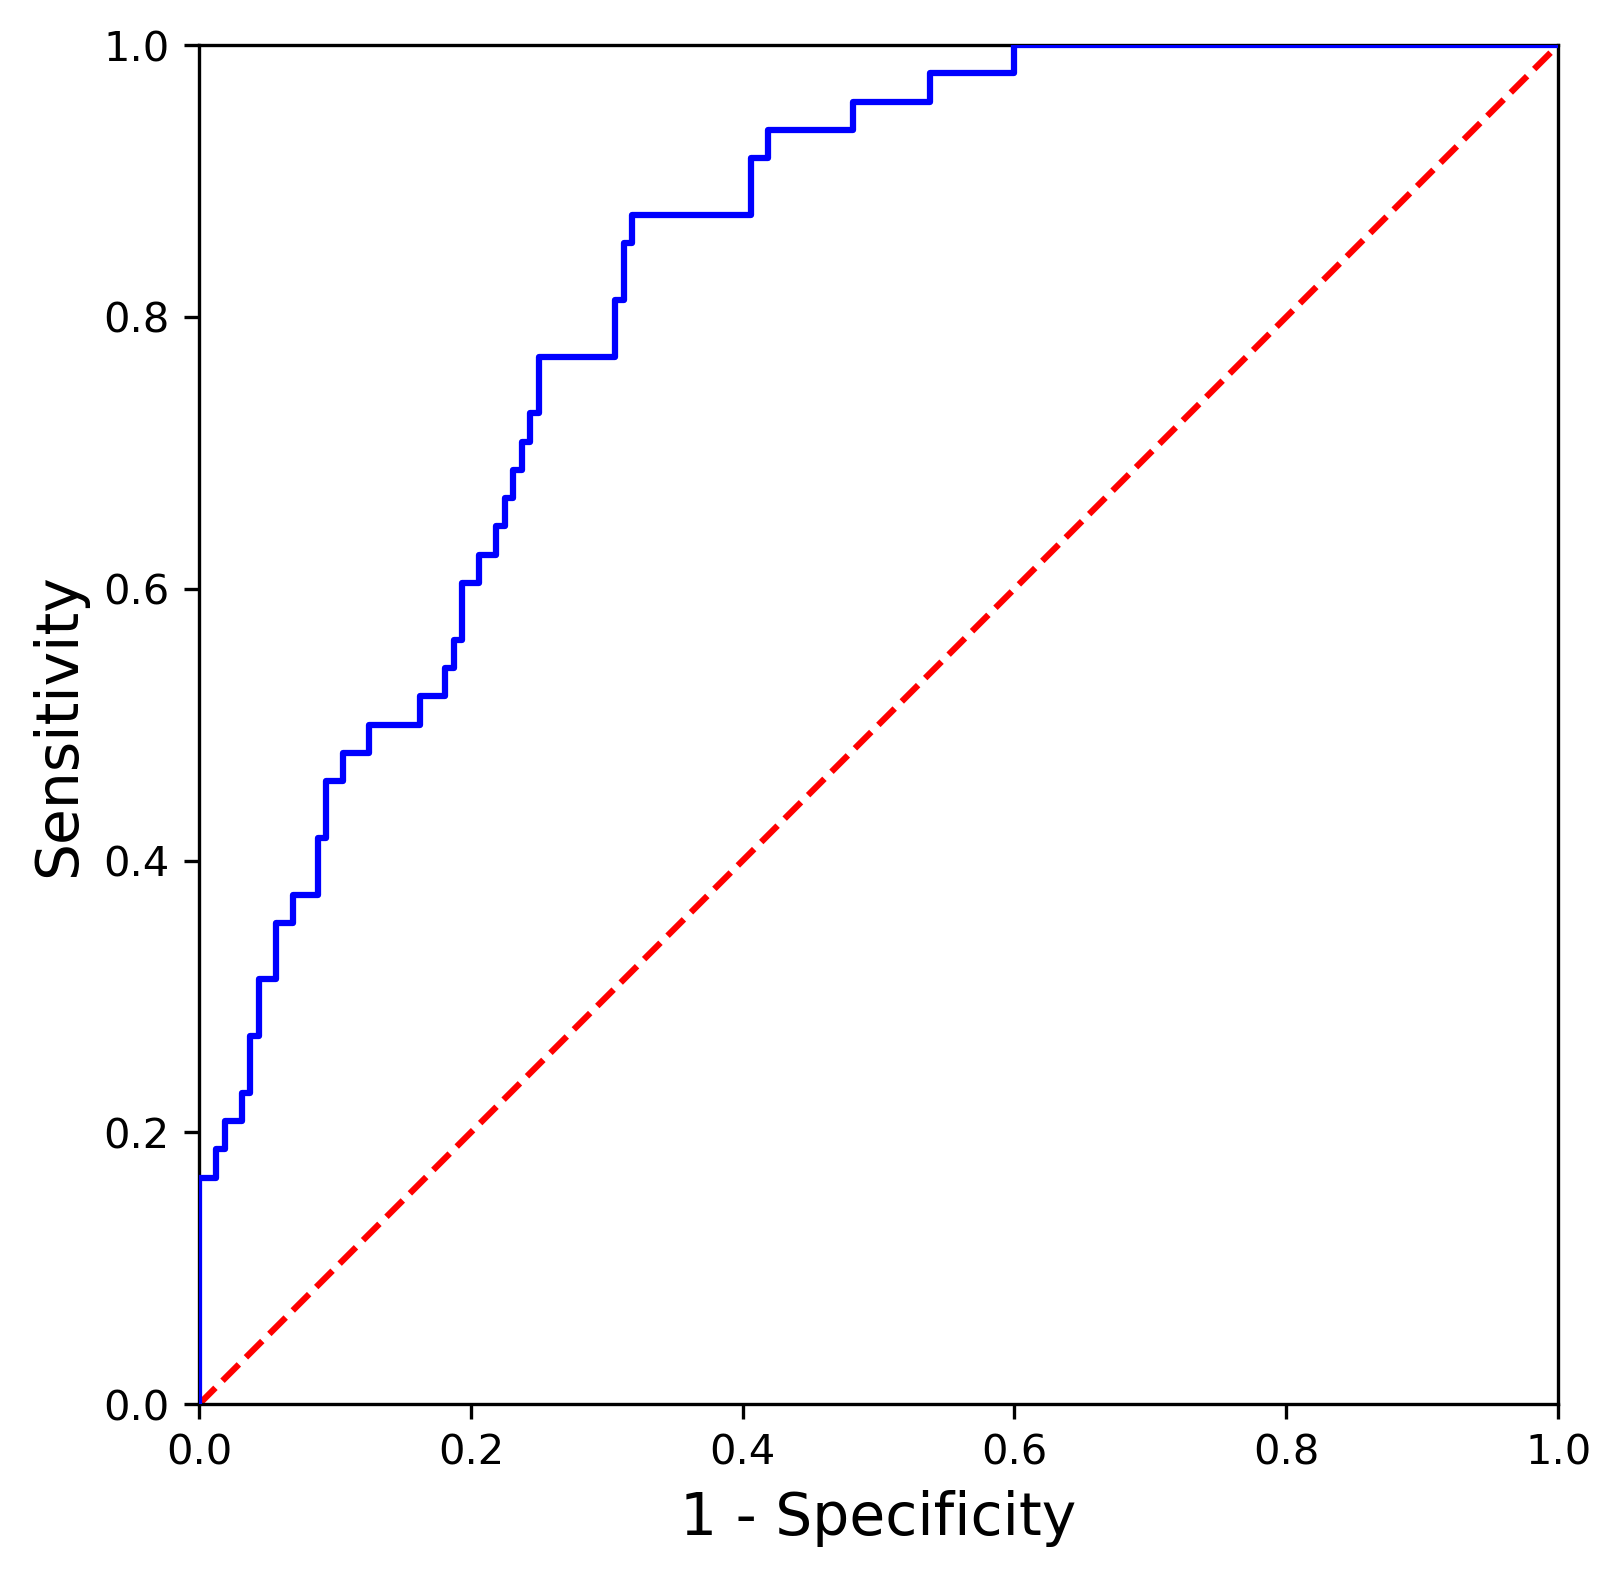

In [16]:
apply_logistic_modelling_and_roc(principal_df, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], fontsize=14)

End!